# Introduction to Brian part 1: Neurons

All Brian scripts start with the following. If you're trying this notebook out in the Jupyter notebook, you should start by running this cell.

In [1]:
from brian2 import *

Later we'll do some plotting in the notebook, so we activate inline plotting in the notebook by doing this:

In [2]:
%matplotlib inline

If you are not using the Jupyter notebook to run this example (e.g. you are using a standard Python terminal, or you copy&paste these example into an editor and run them as a script), then plots will not automatically be displayed. In this case, call the ``show()`` command explicitly after the plotting commands.

## Units system

Brian has a system for using quantities with physical dimensions:

In [3]:
20*volt

20. * volt

All of the basic SI units can be used (volt, amp, etc.) along with all the standard prefixes (m=milli, p=pico, etc.), as well as a few special abbreviations like ``mV`` for millivolt, ``pF`` for picofarad, etc.

In [4]:
1000*amp

1. * kamp

In [5]:
1e6*volt

1. * Mvolt

In [6]:
1000*namp

1. * uamp

Also note that combinations of units with work as expected:

In [7]:
10*nA*5*Mohm

50. * mvolt

And if you try to do something wrong like adding amps and volts, what happens?

In [9]:
#5*amp+10*volt

If you haven't see an error message in Python before that can look a bit overwhelming, but it's actually quite simple and it's important to know how to read these because you'll probably see them quite often.

You should start at the bottom and work up. The last line gives the error type ``DimensionMismatchError`` along with a more specific message (in this case, you were trying to add together two quantities with different SI units, which is impossible).

Working upwards, each of the sections starts with a filename (e.g. ``C:\Users\Dan\...``) with possibly the name of a function, and then a few lines surrounding the line where the error occurred (which is identified with an arrow).

The last of these sections shows the place in the function where the error actually happened. The section above it shows the function that called that function, and so on until the first section will be the script that you actually run. This sequence of sections is called a traceback, and is helpful in debugging.

If you see a traceback, what you want to do is start at the bottom and scan up the sections until you find your own file because that's most likely where the problem is. (Of course, your code might be correct and Brian may have a bug in which case, please let us know on the email support list.)

## A simple model

Let's start by defining a simple neuron model. In Brian, all models are defined by systems of differential equations. Here's a simple example of what that looks like:

In [10]:
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

In Python, the notation ``'''`` is used to begin and end a multi-line string. So the equations are just a string with one line per equation. The equations are formatted with standard mathematical notation, with one addition. At the end of a line you write ``: unit`` where ``unit`` is the SI unit of that variable.
Note that this is not the unit of the two sides of the equation (which would be ``1/second``), but the unit of the *variable* defined by the equation, i.e. in this case $v$.

Now let's use this definition to create a neuron.

In [11]:
G = NeuronGroup(1, eqs)

In Brian, you only create groups of neurons, using the class ``NeuronGroup``. The first two arguments when you create one of these objects are the number of neurons (in this case, 1) and the defining differential equations.

Let's see what happens if we didn't put the variable ``tau`` in the equation:

In [12]:
eqs = '''
dv/dt = 1-v : 1
'''
G = NeuronGroup(1, eqs)
run(100*ms)

BrianObjectException: Error encountered with object named 'neurongroup_1'.
Object was created here (most recent call only, full details in debug log):
  File '/var/folders/kw/zy3d16jx1kq51fgn__3jnxgh0000gn/T/ipykernel_44842/2653720013.py', line 4, in <cell line: 4>
    G = NeuronGroup(1, eqs)

An error occurred when preparing an object. (See above for original error message and traceback.)

An error is raised, but why? The reason is that the differential equation is now dimensionally inconsistent. The left hand side ``dv/dt`` has units of ``1/second`` but the right hand side ``1-v`` is dimensionless. People often find this behaviour of Brian confusing because this sort of equation is very common in mathematics. However, for quantities with physical dimensions it is incorrect because the results would change depending on the unit you measured it in. For time, if you measured it in seconds the same equation would behave differently to how it would if you measured time in milliseconds. To avoid this, we insist that you always specify dimensionally consistent equations.

Now let's go back to the good equations and actually run the simulation.

In [13]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs)
run(100*ms)

INFO       No numerical integration method specified for group 'neurongroup', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]


First off, ignore that ``start_scope()`` at the top of the cell. You'll see that in each cell in this tutorial where we run a simulation. All it does is make sure that any Brian objects created before the function is called aren't included in the next run of the simulation.

Secondly, you'll see that there is an "INFO" message about not specifying the numerical integration method. This is harmless and just to let you know what method we chose, but we'll fix it in the next cell by specifying the method explicitly.

So, what has happened here? Well, the command ``run(100*ms)`` runs the simulation for 100 ms. We can see that this has worked by printing the value of the variable ``v`` before and after the simulation.

In [14]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
print('Before v = %s' % G.v[0])
run(100*ms)
print('After v = %s' % G.v[0])

Before v = 0.0
After v = 0.9999546000702376


By default, all variables start with the value 0. Since the differential equation is ``dv/dt=(1-v)/tau`` we would expect after a while that ``v`` would tend towards the value 1, which is just what we see. Specifically, we'd expect ``v`` to have the value ``1-exp(-t/tau)``. Let's see if that's right.

In [15]:
print('Expected value of v = %s' % (1-exp(-100*ms/tau)))

Expected value of v = 0.9999546000702375


Good news, the simulation gives the value we'd expect!

Now let's take a look at a graph of how the variable ``v`` evolves over time.

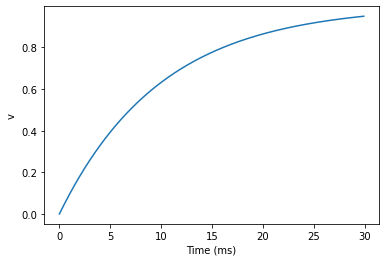

In [16]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=True)

run(30*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

This time we only ran the simulation for 30 ms so that we can see the behaviour better. It looks like it's behaving as expected, but let's just check that analytically by plotting the expected behaviour on top.

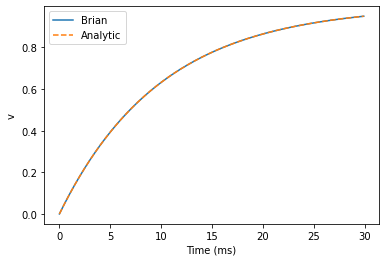

In [26]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

plot(M.t/ms, M.v[0], 'C0', label='Brian')
plot(M.t/ms, 1-exp(-M.t/tau), 'C1--',label='Analytic')
xlabel('Time (ms)')
ylabel('v')
legend();

As you can see, the blue (Brian) and dashed orange (analytic solution) lines coincide.

In this example, we used the object ``StateMonitor`` object. This is used to record the values of a neuron variable while the simulation runs. The first two arguments are the group to record from, and the variable you want to record from. We also specify ``record=0``. This means that we record all values for neuron 0. We have to specify which neurons we want to record because in large simulations with many neurons it usually uses up too much RAM to record the values of all neurons.

Now try modifying the equations and parameters and see what happens in the cell below.

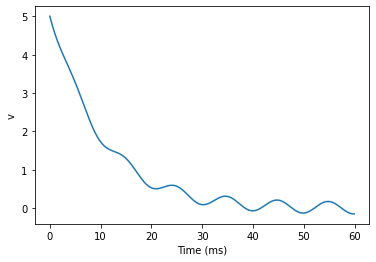

In [27]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (sin(2*pi*100*Hz*t)-v)/tau : 1
'''

# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, 'v', record=0)

G.v = 5 # initial value

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

## Adding spikes

So far we haven't done anything neuronal, just played around with differential equations. Now let's start adding spiking behaviour.

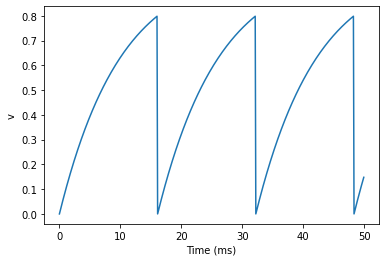

In [37]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

We've added two new keywords to the ``NeuronGroup`` declaration: ``threshold='v>0.8'`` and ``reset='v = 0'``. What this means is that when ``v>0.8`` we fire a spike, and immediately reset ``v = 0`` after the spike. We can put any expression and series of statements as these strings.

As you can see, at the beginning the behaviour is the same as before until ``v`` crosses the threshold ``v>0.8`` at which point you see it reset to 0. You can't see it in this figure, but internally Brian has registered this event as a spike. Let's have a look at that.

In [36]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

spikemon = SpikeMonitor(G)

run(50*ms)

print('Spike times: %s' % spikemon.t[:])

Spike times: [16.  32.1 48.2] ms


The ``SpikeMonitor`` object takes the group whose spikes you want to record as its argument and stores the spike times in the variable ``t``. Let's plot those spikes on top of the other figure to see that it's getting it right.

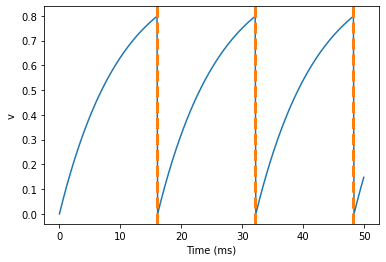

In [38]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

Here we've used the ``axvline`` command from ``matplotlib`` to draw an orange, dashed vertical line at the time of each spike recorded by the ``SpikeMonitor``.

Now try changing the strings for ``threshold`` and ``reset`` in the cell above to see what happens.

## Refractoriness

A common feature of neuron models is refractoriness. This means that after the neuron fires a spike it becomes refractory for a certain duration and cannot fire another spike until this period is over. Here's how we do that in Brian.

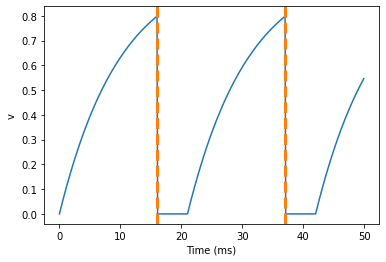

In [39]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

As you can see in this figure, after the first spike, ``v`` stays at 0 for around 5 ms before it resumes its normal behaviour. To do this, we've done two things. Firstly, we've added the keyword ``refractory=5*ms`` to the ``NeuronGroup`` declaration. On its own, this only means that the neuron cannot spike in this period (see below), but doesn't change how ``v`` behaves. In order to make ``v`` stay constant during the refractory period, we have to add ``(unless refractory)`` to the end of the definition of ``v`` in the differential equations. What this means is that the differential equation determines the behaviour of ``v`` unless it's refractory in which case it is switched off.

Here's what would happen if we didn't include ``(unless refractory)``. Note that we've also decreased the value of ``tau`` and increased the length of the refractory period to make the behaviour clearer.

Spike times: [ 8. 23. 38.] ms


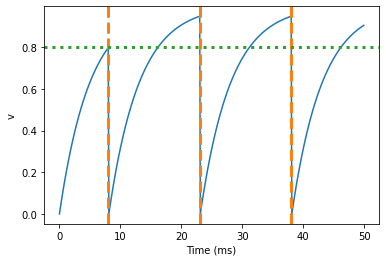

In [40]:
start_scope()

tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=15*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
axhline(0.8, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('v')
print("Spike times: %s" % spikemon.t[:])

So what's going on here? The behaviour for the first spike is the same: ``v`` rises to 0.8 and then the neuron fires a spike at time 8 ms before immediately resetting to 0. Since the refractory period is now 15 ms this means that the neuron won't be able to spike again until time 8 + 15 = 23 ms. Immediately after the first spike, the value of ``v`` now instantly starts to rise because we didn't specify ``(unless refractory)`` in the definition of ``dv/dt``. However, once it reaches the value 0.8 (the dashed green line) at time roughly 8 ms it doesn't fire a spike even though the threshold is ``v>0.8``. This is because the neuron is still refractory until time 23 ms, at which point it fires a spike.

Note that you can do more complicated and interesting things with refractoriness. See the full documentation for more details about how it works.

## Multiple neurons

So far we've only been working with a single neuron. Let's do something interesting with multiple neurons.

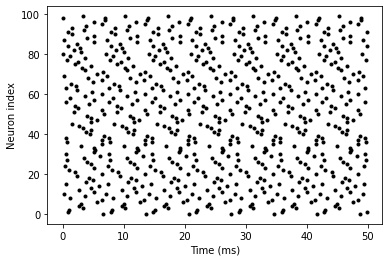

In [41]:
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

This shows a few changes. Firstly, we've got a new variable ``N`` determining the number of neurons. Secondly, we added the statement ``G.v = 'rand()'`` before the run. What this does is initialise each neuron with a different uniform random value between 0 and 1. We've done this just so each neuron will do something a bit different. The other big change is how we plot the data in the end.

As well as the variable ``spikemon.t`` with the times of all the spikes, we've also used the variable ``spikemon.i`` which gives the corresponding neuron index for each spike, and plotted a single black dot with time on the x-axis and neuron index on the y-value. This is the standard "raster plot" used in neuroscience.

## Parameters

To make these multiple neurons do something more interesting, let's introduce per-neuron parameters that don't have a differential equation attached to them.

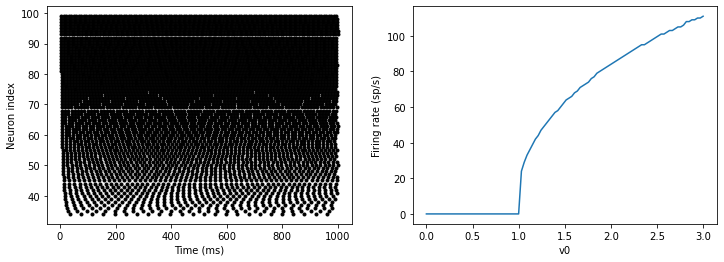

In [42]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

The line ``v0 : 1`` declares a new per-neuron parameter ``v0`` with units ``1`` (i.e. dimensionless).

The line ``G.v0 = 'i*v0_max/(N-1)'`` initialises the value of v0 for each neuron varying from 0 up to ``v0_max``. The symbol ``i`` when it appears in strings like this refers to the neuron index.

So in this example, we're driving the neuron towards the value ``v0`` exponentially, but when ``v`` crosses ``v>1``, it fires a spike and resets. The effect is that the rate at which it fires spikes will be related to the value of ``v0``. For ``v0<1`` it will never fire a spike, and as ``v0`` gets larger it will fire spikes at a higher rate. The right hand plot shows the firing rate as a function of the value of ``v0``. This is the I-f curve of this neuron model.

Note that in the plot we've used the ``count`` variable of the ``SpikeMonitor``: this is an array of the number of spikes each neuron in the group fired. Dividing this by the duration of the run gives the firing rate.

## Stochastic neurons

Often when making models of neurons, we include a random element to model the effect of various forms of neural noise. In Brian, we can do this by using the symbol ``xi`` in differential equations. Strictly speaking, this symbol is a "stochastic differential" but you can sort of thinking of it as just a Gaussian random variable with mean 0 and standard deviation 1. We do have to take into account the way stochastic differentials scale with time, which is why we multiply it by ``tau**-0.5`` in the equations below (see a textbook on stochastic differential equations for more details).
Note that we also changed the ``method`` keyword argument to use ``'euler'`` (which stands for the [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)); the ``'exact'`` method that we used earlier is not applicable to stochastic differential equations.

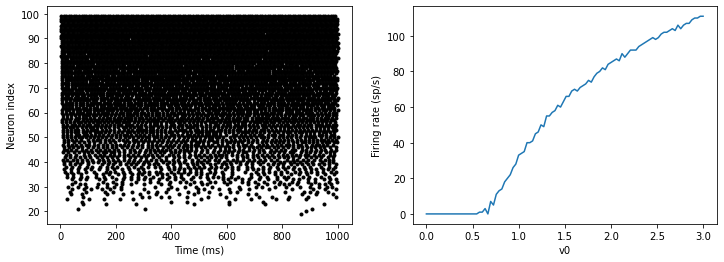

In [43]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

That's the same figure as in the previous section but with some noise added. Note how the curve has changed shape: instead of a sharp jump from firing at rate 0 to firing at a positive rate, it now increases in a sigmoidal fashion. This is because no matter how small the driving force the randomness may cause it to fire a spike.

## End of tutorial

That's the end of this part of the tutorial. The cell below has another example. See if you can work out what it is doing and why. Try adding a ``StateMonitor`` to record the values of the variables for one of the neurons to help you understand it.

You could also try out the things you've learned in this cell.

Once you're done with that you can move on to the next tutorial on Synapses.

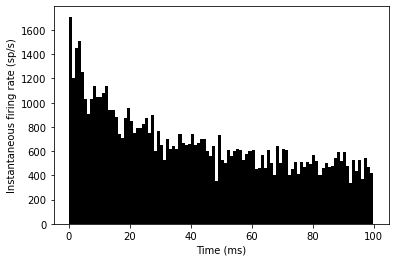

In [53]:
start_scope()

N = 1000
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=4)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

In [57]:
test = statemon.v

In [59]:
test.shape

(1, 1000)